<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-09/Custom-Cartoon-GAN/Selfie2BitMoji-Modified-Cartoon-GAN/Custom-Cartoon-GAN-Selfie2bitMoji.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.4.0


# Load and Unzip Data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip /content/gdrive/MyDrive/GAN_datasets/photo2cartoon.zip -d /

In [ ]:
import glob
faces = glob.glob('/trainA/*.jpg')
cartoons = glob.glob("/trainB/*.png")
faces_test = glob.glob('/testA/*.jpg')
cartoons_test = glob.glob('/testB/*.png')

In [ ]:
import glob
path = "/Users/k15/Downloads/selfie2anime/"
faces = glob.glob(path + 'trainA/*.jpg')
bitmojis = glob.glob(path + "../BitmojiDataset/*/*.jpg")
faces_test = glob.glob(path + 'testA/*.jpg')

In [ ]:
len(faces), len(bitmojis), len(faces_test)

(3400, 4084, 100)

In [ ]:
import cv2
for file in bitmojis[:10]:
    img = cv2.imread(file)
    print (img.shape)

(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)


# Display few Samples

Human Faces


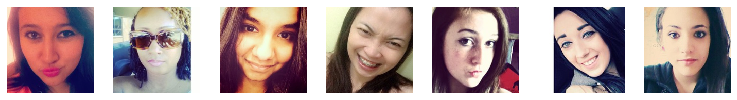

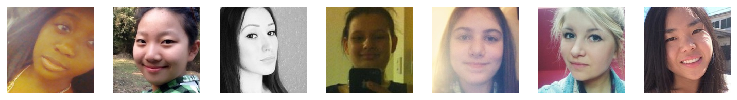

--------------------------------------------------------------------------------
Bitmojis


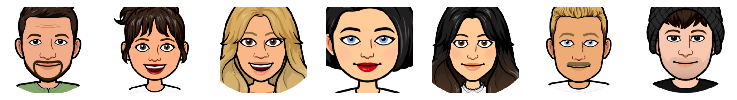

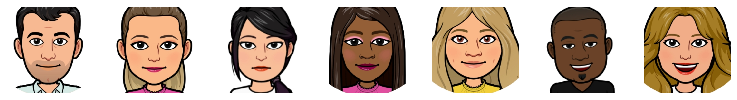

In [ ]:
print ("Human Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(7):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Bitmojis")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(7):
        file = np.random.choice(bitmojis)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[80:350,65:335]
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Define Generator Model (U-Net Like)

In [ ]:
import tensorflow_addons as tfa

In [ ]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tfa.layers.InstanceNormalization()(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [ ]:
def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))
    target_style = tensorflow.keras.layers.Input(shape=(16, 16, 512))

    e1 = encoder_layer(source_image, 64, bn=False)
    e2 = encoder_layer(e1, 128)
    e3 = encoder_layer(e2, 256)
    # e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e3, 512)
    e6 = encoder_layer(e5, 512)
    e7 = encoder_layer(e6, 512)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 512)
    d2 = decoder_layer(d1, e6, 512)
    d3 = decoder_layer(d2, e5, 512)
    # d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d3, e3, 256)
    d5 = tensorflow.keras.layers.Concatenate()([d5, target_style])
    d6 = decoder_layer(d5, e2, 128)
    d7 = decoder_layer(d6, e1, 64)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, target_style, translated_image

source_image, target_style, translated_image = make_generator()
generator_network = tensorflow.keras.models.Model(inputs=[source_image, target_style], outputs=translated_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Define Discriminator Network

In [ ]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [ ]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    # x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization_11 (I (None, 32, 32, 128)       256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       5245

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Load and extract VGG features

In [ ]:
image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

pre_trained_vgg = tensorflow.keras.applications.vgg19.VGG19(weights='imagenet', input_shape=(128, 128, 3), include_top=False)
pre_trained_vgg_model = tensorflow.keras.models.Model(inputs=pre_trained_vgg.input, outputs=pre_trained_vgg.get_layer('block4_conv4').output)

pre_trained_image_feautures = pre_trained_vgg_model(image_input)

custom_vgg = tensorflow.keras.models.Model(inputs=image_input, outputs=pre_trained_image_feautures)
print (custom_vgg.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 16, 16, 512)       10585152  
Total params: 10,585,152
Trainable params: 10,585,152
Non-trainable params: 0
_________________________________________________________________
None


# Define Customized-face2bitmoji-GAN

In [ ]:
source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))
target_features = tensorflow.keras.layers.Input(shape=(16, 16, 512))

# Domain Transfer
custom_vgg.trainable=False
fake_bitmoji = generator_network([source_image, target_features])
  
discriminator_network.trainable=False

# Tell Real vs Fake
real_vs_fake = discriminator_network(fake_bitmoji)

face2bitmoji_gan = tensorflow.keras.models.Model(inputs =[source_image, target_features], outputs = [real_vs_fake, fake_bitmoji, fake_bitmoji])
face2bitmoji_gan.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 16, 16, 512) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  42882051    input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 8, 8, 1)      2766529     model[0][0]                

# Custom Loss (vgg content Loss)

In [ ]:
def custom_gan_loss(y_true, y_pred):
    custom_vgg.trainable=False
    y_true_features = custom_vgg(y_true)
    y_pred_features = custom_vgg(y_pred)
    content_loss = tensorflow.compat.v1.losses.absolute_difference(y_true_features, y_pred_features)
    return content_loss

# Compiling Models

In [ ]:
face2bitmoji_gan.compile(loss=['mse', custom_gan_loss, custom_gan_loss],\
                                     optimizer=adam_optimizer, loss_weights=[1, 1, 0.1])

# Define Data Generators

In [ ]:
def faces_to_cartoons(faces, styles, generator_network):
    styles = custom_vgg(styles)
    generated_samples = generator_network.predict_on_batch([faces, styles])
    return generated_samples

def do_smoothing(img):
    # taken from https://github.com/penny4860/Keras-CartoonGan/blob/master/cartoon/utils.py
    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)

    rgb_img = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    pad_img = np.pad(rgb_img, ((2,2), (2,2), (0,0)), mode='reflect')
    edges = cv2.Canny(gray_img, 100, 200)
    dilation = cv2.dilate(edges, kernel)

    gauss_img = np.copy(rgb_img)
    idx = np.where(dilation != 0)
    for i in range(np.sum(dilation != 0)):
        gauss_img[idx[0][i], idx[1][i], 0] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
        gauss_img[idx[0][i], idx[1][i], 1] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
        gauss_img[idx[0][i], idx[1][i], 2] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))

    return gauss_img

def get_training_samples(batch_size):
    random_files = np.random.choice(faces, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    face_images = np.array(images)

    random_files = np.random.choice(bitmojis, size=batch_size)
    images = []
    smooth_images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[80:350,65:335]
        img = cv2.resize(img, (128, 128))
        smooth = do_smoothing(img)
        images.append((img-127.5)/127.5)
        smooth_images.append((smooth-127.5)/127.5)
    cartoon_images = np.array(images)
    cartoon_smooth_images = np.array(smooth_images)
    return face_images, cartoon_images, cartoon_smooth_images

def show_generator_results(generator_network):
    images = []
    styles=[]
    for j in range(7):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)
        
        file = np.random.choice(bitmojis)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img[80:350,65:335]
        img = cv2.resize(img, (128, 128))
        styles.append(img)

    print ('Human Face Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Bitmojis Version')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        style = (styles[j]-127.5)/127.5
        output = faces_to_cartoons(np.array([img]), np.array([style]), generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

## Check smoother version of BitMojis

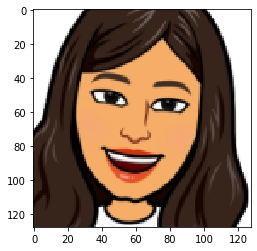

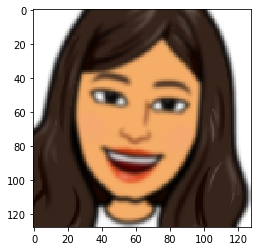

In [ ]:
img = cv2.imread(bitmojis[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img[80:350,65:335]
img = cv2.resize(img, (128, 128))
plt.imshow(img)
plt.show()
plt.imshow(do_smoothing(img))
plt.show()

# Training Selfie2Bitmoji (Custom Cartoon GAN)

In [ ]:
len(faces), len(bitmojis)

(3400, 4084)

Human Face Images


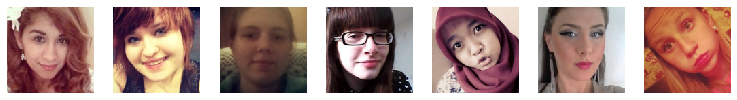

Bitmojis Version


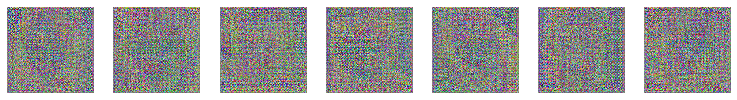

Epoch:0, Step:0, D-Loss:8.005, D-Acc:50.521, G-Loss:4.169
Epoch:0, Step:100, D-Loss:0.493, D-Acc:57.292, G-Loss:2.610
Human Face Images


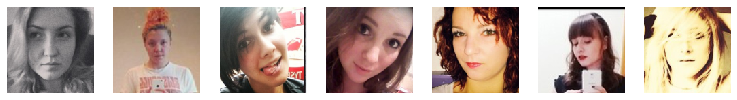

Bitmojis Version


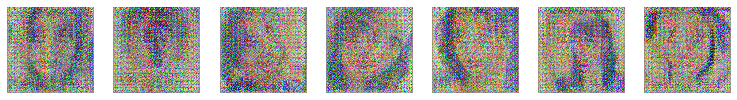

Epoch:0, Step:200, D-Loss:0.262, D-Acc:61.458, G-Loss:2.266
Epoch:0, Step:300, D-Loss:0.392, D-Acc:54.688, G-Loss:2.175
Human Face Images


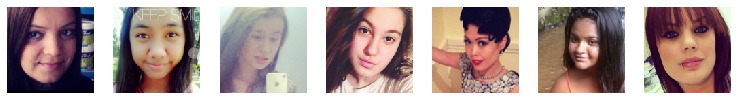

Bitmojis Version


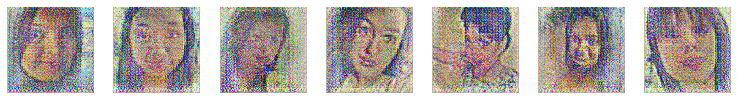

Epoch:0, Step:400, D-Loss:0.235, D-Acc:63.542, G-Loss:2.150
Epoch:0, Step:500, D-Loss:0.296, D-Acc:60.417, G-Loss:2.060
Human Face Images


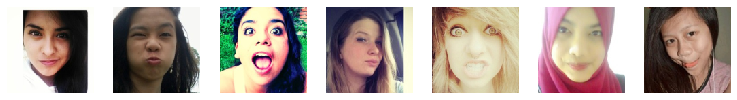

Bitmojis Version


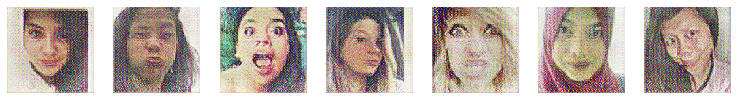

Epoch:0, Step:600, D-Loss:0.270, D-Acc:52.604, G-Loss:2.007
Epoch:0, Step:700, D-Loss:0.364, D-Acc:60.417, G-Loss:1.995
Human Face Images


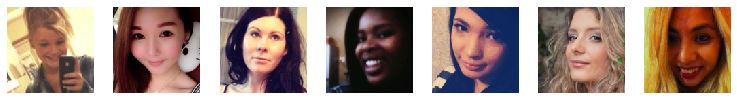

Bitmojis Version


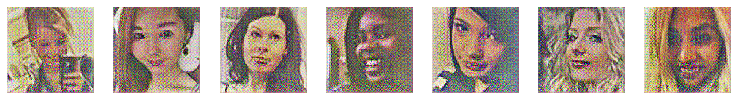

Epoch:0, Step:800, D-Loss:0.164, D-Acc:82.812, G-Loss:1.835
Epoch:0, Step:900, D-Loss:0.195, D-Acc:73.438, G-Loss:1.800
Human Face Images


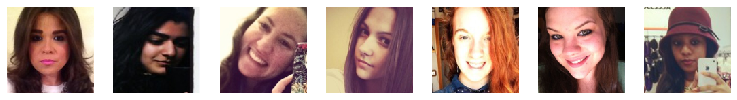

Bitmojis Version


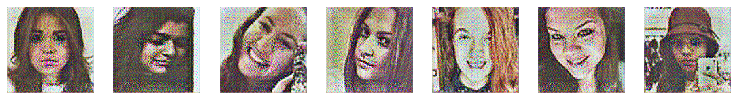

Epoch:0, Step:1000, D-Loss:0.130, D-Acc:83.333, G-Loss:2.000
Epoch:0, Step:1100, D-Loss:0.120, D-Acc:84.375, G-Loss:2.078
Human Face Images


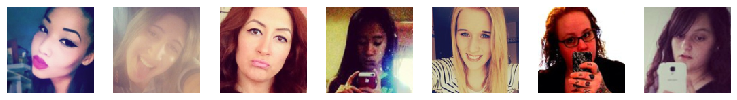

Bitmojis Version


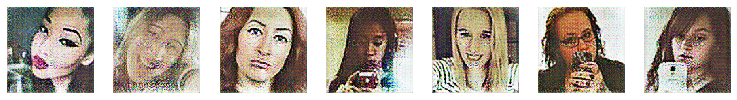

Epoch:0, Step:1200, D-Loss:0.073, D-Acc:94.792, G-Loss:2.007
Epoch:0, Step:1300, D-Loss:0.355, D-Acc:51.042, G-Loss:2.169
Human Face Images


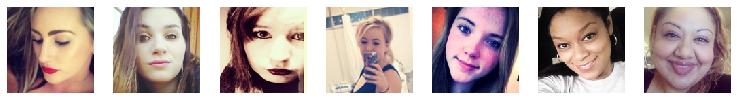

Bitmojis Version


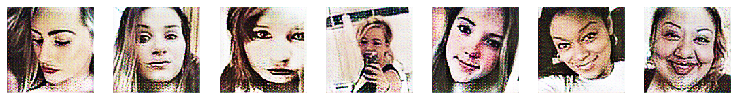

Epoch:0, Step:1400, D-Loss:0.057, D-Acc:96.875, G-Loss:1.983
Epoch:0, Step:1500, D-Loss:0.063, D-Acc:99.479, G-Loss:2.489
Human Face Images


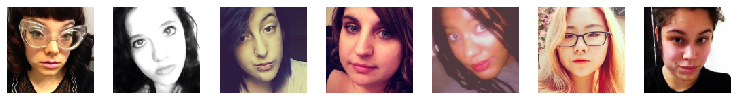

Bitmojis Version


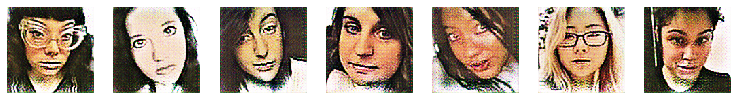

Epoch:0, Step:1600, D-Loss:0.332, D-Acc:66.667, G-Loss:2.332
Epoch:0, Step:1700, D-Loss:0.157, D-Acc:78.125, G-Loss:2.213
Human Face Images


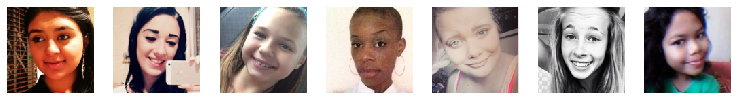

Bitmojis Version


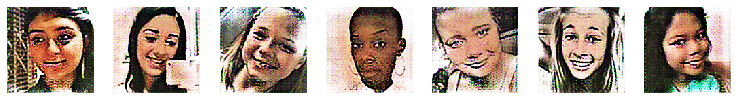

Epoch:0, Step:1800, D-Loss:0.111, D-Acc:86.458, G-Loss:2.295
Epoch:0, Step:1900, D-Loss:0.044, D-Acc:97.917, G-Loss:2.244
Human Face Images


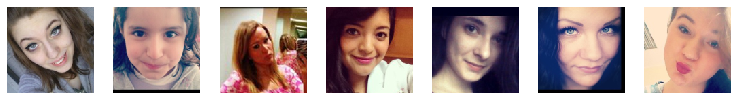

Bitmojis Version


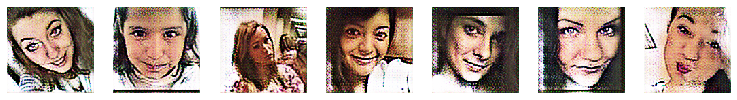

Epoch:0, Step:2000, D-Loss:0.071, D-Acc:94.271, G-Loss:2.368
Epoch:0, Step:2100, D-Loss:0.080, D-Acc:95.833, G-Loss:2.335
Human Face Images


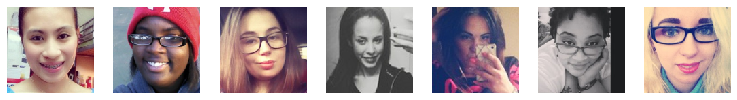

Bitmojis Version


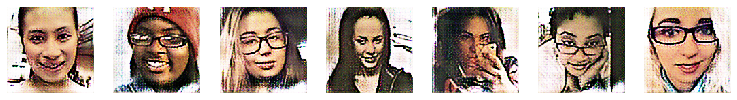

Epoch:0, Step:2200, D-Loss:0.087, D-Acc:90.625, G-Loss:2.367
Epoch:0, Step:2300, D-Loss:0.073, D-Acc:93.750, G-Loss:2.049
Human Face Images


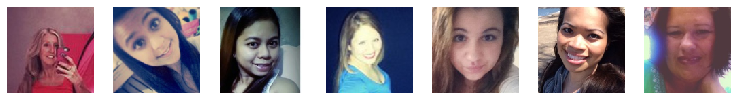

Bitmojis Version


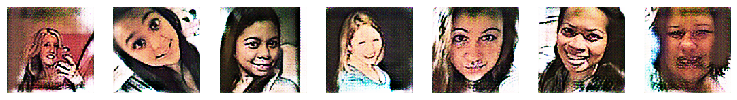

Epoch:0, Step:2400, D-Loss:0.137, D-Acc:78.646, G-Loss:2.938


KeyboardInterrupt: 

In [ ]:
epochs = 500
batch_size = 1
steps = 4000

for i in range(0, epochs):
    for j in range(steps): 
        if j%200 == 0:
            show_generator_results(generator_network)
            #generator_network.save("/Users/k15/Downloads/BitmojiDataset/weights/mod_" + str(i) + "_" + str(j))

        human_faces, cartoon_faces, smooth_cartoon_faces = get_training_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        custom_vgg.trainable=False
        styles = custom_vgg(cartoon_faces)
        fake_cartoon_faces = generator_network([human_faces, styles])
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(cartoon_faces, real_patch)
        loss_d_smooth = discriminator_network.train_on_batch(smooth_cartoon_faces, fake_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_cartoon_faces, fake_patch)
        
        loss_d = np.add(loss_d_real, np.add(loss_d_smooth, loss_d_fake))/3.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        discriminator_network.trainable=False

        # Updating Generator weights
        loss_g = face2bitmoji_gan.train_on_batch([human_faces, styles],[real_patch, human_faces, cartoon_faces])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))
            

# Results

In [ ]:
epochs = 500
batch_size = 1
steps = 4000

for i in range(0, epochs):
    for j in range(steps): 
        if j%100 == 0:
            show_generator_results(generator_network)
            generator_network.save("/Users/k15/Downloads/BitmojiDataset/weights/mod_" + str(i) + "_" + str(j))

        human_faces, cartoon_faces, smooth_cartoon_faces = get_training_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        custom_vgg.trainable=False
        styles = custom_vgg(cartoon_faces)
        fake_cartoon_faces = generator_network([human_faces, styles])
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(cartoon_faces, real_patch)
        loss_d_smooth = discriminator_network.train_on_batch(smooth_cartoon_faces, fake_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_cartoon_faces, fake_patch)
        
        loss_d = np.add(loss_d_real, np.add(loss_d_smooth, loss_d_fake))/3.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        discriminator_network.trainable=False

        # Updating Generator weights
        loss_g = face2bitmoji_gan.train_on_batch([human_faces, styles],[real_patch, human_faces, cartoon_faces])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))
            